In [1]:
import sys
import os
#import torch
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

#from torch import nn
from pathlib import Path
from scipy.stats import linregress, spearmanr
from typing import Union
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.pipeline import Pipeline
from matplotlib.gridspec import GridSpec

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath, prep_and_resample
from Medley.utils import data_for_pcolormesh, udomains, regions, tscolnames
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample,remove_bottleneck, make_pipeline
from Medley.crossval import SpatiotemporalSplit
from Medley.estimators import return_estimator
from Medley.visualization import plot_stations, plot_plus_stations
from Medley.interpretation import return_experiments, load_pred_results, return_explainer

/scistor/ivm/jsn295/SUPERVENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
warnings.simplefilter('ignore',category=RuntimeWarning)
warnings.simplefilter('ignore',category=UserWarning)

## Timeseries
Length, data source, literature, directionality

In [3]:
preds = get_monthly_data()
# Red is drying, blue is wettening, grey = unknown.
directionality = pd.Series(['blue','blue','blue','blue', #enso 12, 3,34,4
                            'grey','grey', # amo
                            'blue', # amoc
                            'red','red', # nao
                            'red', # snao
                            'red','red', # ao
                            'blue', # east atl
                            'grey', # pdo
                            'red', # gmst
                            'red','blue', # mjo3, mjo6
                            'grey', # qbo
                            'red','red','grey','blue','grey','grey', # med250 latmax, 20,30,40,50,60 
                            'grey','grey','grey','grey','grey','grey', # atl250 latmax, 20,30,40,50,60 
                            'grey','red','blue','grey','grey','red', # med500 latmax, 20,30,40,50,60 
                            'red','blue','grey','grey','red','red', # atl500 latmax, 20,30,40,50,60 
                            'red', # vortex
                            'grey','grey','grey','grey','grey','grey', # atleke latmax, 20,30,40,50,60 
                            'grey','red','red', # iod, west ind, east ind.
                           ],index = preds.columns)

In [4]:
valid = ~preds.isnull()
for i, col in enumerate(valid.columns):
    valid.loc[:,col] = np.where(valid.loc[:,col], i, np.nan)


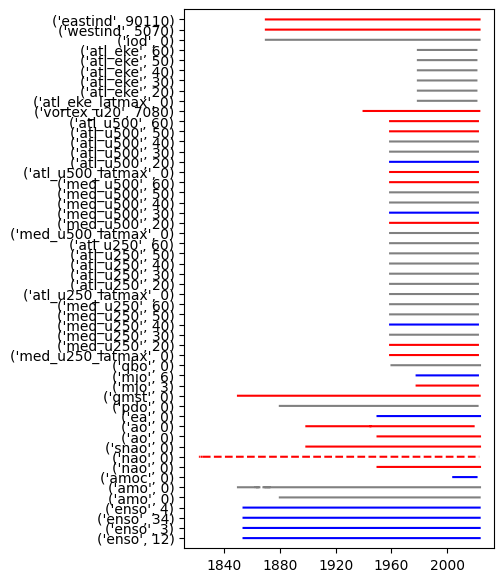

In [5]:
fig, ax = plt.subplots(figsize = (4,7))
for col in valid.columns:
    if 'station' in col:
        sty = 'dashed'
    else:
        sty = 'solid'
    ax.plot(valid.index, valid.loc[:,col], ls = sty, color = directionality.loc[col])
#valid.plot(color = 'grey', ax = ax, legend = False)
ax.set_ylim(-1,len(valid.columns))
ax.set_yticks(np.arange(0,len(valid.columns)))
ax.set_yticklabels(valid.columns.droplevel(-1).to_flat_index())
plt.show()

## Regions, local trend and aggregated timeseries.

In [6]:
spi_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3.h5')
spi_ecad.index.name = 'time'
spi_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3_stations.h5')

In [19]:
min_count = 60 # So basically 60/3months = 20 seasons.
spi_ecad_1950 = spi_ecad.loc[slice('1950',None),:].stack().to_xarray()
# temporal subsetting to jfm
timeset = spi_ecad_1950.get_index('time').month.map(lambda m: m in list(range(4)))
spi_ecad_1950 = spi_ecad_1950.sel(time = timeset)
spi_ecad_1950.attrs['units'] = 'std'
#spi_ecad_1950.groupby(spi_ecad_1950.time.dt.year).mean()
spi_trend = trendfit_robust(spi_ecad_1950, standardize=False, min_count = min_count).sel(what = 'slope')
spi_trend = spi_trend * 10 # To std/decade
spi_trend = spi_trend.to_pandas().dropna()
#spi_trend = spi_trend.loc[spi_trend.abs().sort_values().index] # Sorting by absolute value of the trend
spi_trend = spi_trend.sort_values(ascending = False) # sorting by negativity of the trend

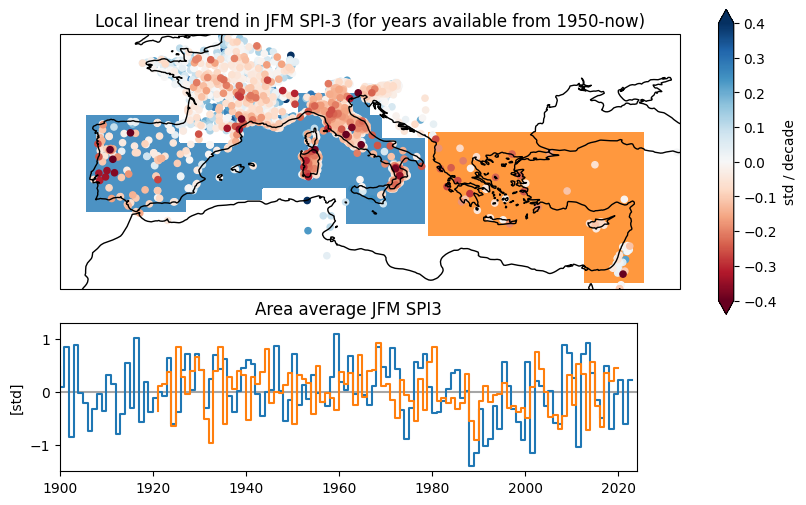

In [20]:
fig = plt.figure(figsize=(10,6),facecolor='white')

gs = GridSpec(nrows = 9, ncols=8, wspace=0.2, hspace = 0.2)
ax1 = fig.add_subplot(gs[:6,:], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[6:,:6])

shading = 'nearest'
for i, regionname in enumerate(['medwest','medeast']):
    _, y_agg, _ = prep_and_resample(target_region = regions[regionname], target_var='SPI3', minsamples = 10, 
                                    resampling = 'single', resampling_kwargs = dict(firstmonth = 1, lastmonth = 3))
    y_agg = y_agg.dropna()
    ax2.step(y_agg.index, y_agg)
    mask = makemask(regions[regionname])
    dat = xr.where(mask, mask, np.nan)
    lat, lon, dat = data_for_pcolormesh(dat, shading = shading)
    ax1.contourf(lat, lon, dat, transform = ccrs.PlateCarree(), colors = list(mcolors.TABLEAU_COLORS.keys())[i], 
               alpha = 0.8)

fig, ax1, im = plot_stations(stat = spi_trend,
                            statloc=spi_ecad_locs, fig = fig, ax = ax1, 
                            cbar= True, 
                            scatter_kwargs={'s':20,#'edgecolors':'black','linewidths':0.1,
                                            'vmin': -0.4, 'vmax' : 0.4, 'cmap':'RdBu'},
                           cbar_kwargs = dict(extend = 'both', label = 'std / decade'))
ax1.set_extent((-12,40,29.5,48))
ax1.coastlines()
ax1.set_title('Local linear trend in JFM SPI-3 (for years available from 1950-now)')
ax2.set_title('Area average JFM SPI3')
ax2.set_ylabel('[std]')
ax2.set_xlim((1900,2024))
ax2.set_ylim(-1.5,1.3)
ax2.hlines(0,1900,2024, color = 'grey', alpha = 0.7, zorder = 0)
plt.show()

Picture for France and Corsica changes quite a bit if dryest trends are placed on top.

## Seasonality in target variable trends, and in its relation to predictors

In [3]:
# potential anomalization has no effect on rank correlation, because conducted per month.
preds = get_monthly_data()

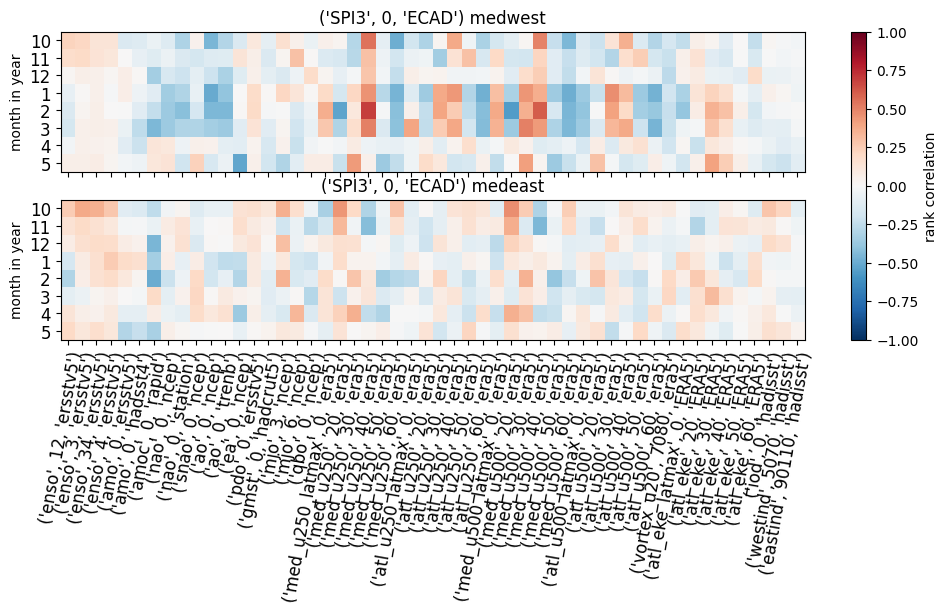

In [5]:
fig, axes = plt.subplots(figsize = (12,4), nrows = 2, sharex = True)
for i, regionname in enumerate(['medwest','medeast']):
    # cannot use prep-and resample, because that is always lagged.
    target = prep_ecad(target_region=regions[regionname], target_var = 'SPI3').to_frame()
    target.columns = pd.MultiIndex.from_tuples([('SPI3',0,'ECAD')], names = tscolnames)
    Xres, yres, _ = simultaneous_resample(X = preds, y = target, firstmonth = 1, lastmonth = 1, average = False)
    # Plotting correlations per month, single months
    months = [10,11,12,1,2,3,4,5]
    othervars = Xres.columns
    corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                            coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
    for month in months:
        Xres, yres, _ = simultaneous_resample(X = preds, y = target, firstmonth = month, lastmonth = month, average = False)
        for var in othervars:
            dat = Xres.loc[:,[var]].join(yres, how = 'inner').dropna(how = 'any')
            corrcoefs.loc[month,var] = spearmanr(dat)[0]
    ax = axes[i]
    im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')
    ax.set_title(f'{target.columns[0]} {regionname}')
    ax.set_yticks(np.arange(corrcoefs.shape[0]))
    ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
    ax.set_ylabel('month in year')
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
fig.colorbar(im, ax = axes, label = 'rank correlation')
plt.show()

## Predictor selection, directionality and accuracy for several models
both eastern and western med

In [3]:
east_med_exps = ['2e2320856f','f15adcb93d'] # ridge regression (mae), random forest (mae) both 1950 onwards
west_med_exps = ['7a000e2f64','deb4021d58'] # ridge (mae), rf regression (r2)  # '627ee28dd0' could be an option but is single (so scores are not comparable)
exps = {'west':west_med_exps,'east':east_med_exps}

In [4]:
max_npredictors = 7
npredictors = pd.RangeIndex(1, max_npredictors + 1, name = 'npredictors')
collection = {}
for regionname, region_exps in exps.items():
    # Loading of experiment log
    exp_dicts = return_experiments(region_exps)
    # Preallocation of objects to capture results
    r2 = pd.DataFrame(np.nan, index = npredictors, columns = exp_dicts.keys())
    nmse = r2.copy(deep = True)
    attributions = {}
    estimators = {}
    for expid, experiment in exp_dicts.items():
        """ recreation of experiments could be wrapped into function """
        Xm, ym, cal = prep_and_resample(**experiment['prep_kwargs'])
        Xm, ym = remove_bottleneck(Xm, ym, **experiment['bottleneck_kwargs'])
        result, cv_scores = load_pred_results(expid) 
        modelclass = return_estimator(experiment['estimator']) 
        model = modelclass(**experiment['estimator_kwargs'])
        cv_kwargs = experiment['cv_kwargs']
        cv_kwargs['time_dim'] = Xm.index
        cv = SpatiotemporalSplit(**cv_kwargs)
        if experiment['pipeline_kwargs']:
            model = make_pipeline(estimator = model, **experiment['pipeline_kwargs'])
        """ until here """
        attr = {}
        for npreds in npredictors:
            if npreds in result.index:
                prednames = result.loc[npreds,'feature_names']
                subset = Xm[list(prednames)]
                # Getting CV scores
                scores = cross_validate(model, X = subset, y = ym.squeeze(), cv = cv, scoring = ['r2','neg_mean_squared_error'])
                r2.loc[npreds, expid] = scores['test_r2'].mean()
                nmse.loc[npreds, expid] = scores['test_neg_mean_squared_error'].mean()
                # Getting directionality (when everything is training data?)
                model.fit(X = subset, y = ym.squeeze())
                # return_explainer deals with pipelines as well. Median (over all samples) of the attribution is probably suboptimal for random forests
                expl = return_explainer(model)
                attr.update({npreds:expl.explain(X = subset)})
        attr = pd.concat(attr).unstack(0)
        attr.columns = attr.columns.set_names(['npredictors'])
        attributions.update({expid:attr})
        estimators.update({expid:experiment['estimator']})
    collection.update({regionname:(r2,nmse,attributions,estimators)})

dropping predictors: MultiIndex([(         ('amoc', 0, 'rapid'), -2),
            (         ('amoc', 0, 'rapid'), -1),
            (           ('mjo', 3, 'ncep'), -2),
            (           ('mjo', 3, 'ncep'), -1),
            (           ('mjo', 6, 'ncep'), -2),
            (           ('mjo', 6, 'ncep'), -1),
            (('atl_eke_latmax', 0, 'ERA5'), -2),
            (('atl_eke_latmax', 0, 'ERA5'), -1),
            (      ('atl_eke', 20, 'ERA5'), -2),
            (      ('atl_eke', 20, 'ERA5'), -1),
            (      ('atl_eke', 30, 'ERA5'), -2),
            (      ('atl_eke', 30, 'ERA5'), -1),
            (      ('atl_eke', 40, 'ERA5'), -2),
            (      ('atl_eke', 40, 'ERA5'), -1),
            (      ('atl_eke', 50, 'ERA5'), -2),
            (      ('atl_eke', 50, 'ERA5'), -1),
            (      ('atl_eke', 60, 'ERA5'), -2),
            (      ('atl_eke', 60, 'ERA5'), -1)],
           names=['variables', 'i_interval'])
samples left: 175
features left: 86
dropping predi

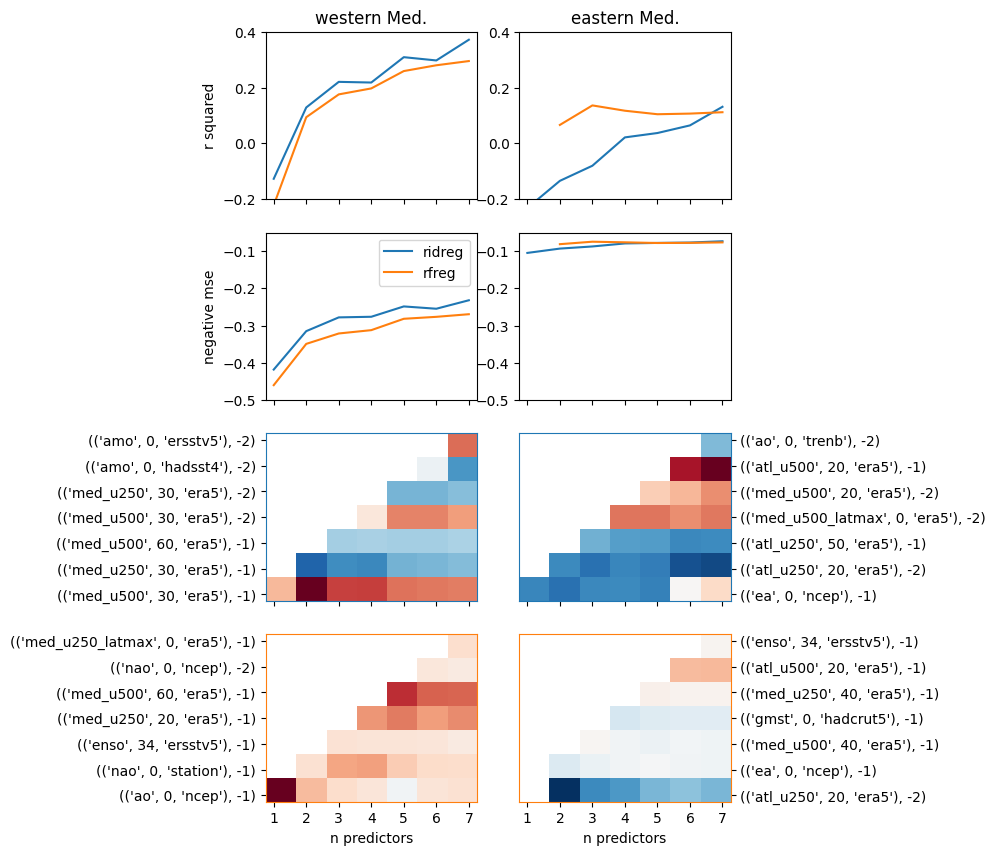

In [21]:
fig, axes = plt.subplots(4,2, squeeze = False, figsize = (6,10), sharex = True, sharey = False)
for j, regionname in enumerate(exps.keys()):
    r2, nmse, attributions, estimators = collection[regionname]
    for i, expid in enumerate(attributions.keys()):
        axes[0,j].plot(r2[expid].index,r2[expid].values, label = estimators[expid])
        axes[1,j].plot(nmse[expid].index,nmse[expid].values, label = estimators[expid])
        data = attributions[expid].reindex(columns = npredictors)
        first_selected = data.count(axis = 1).sort_values(ascending = False)
        data = data.loc[first_selected.index,:]
        vmax = max(data.max(axis = None), abs(data.min(axis = None)))
        #axes[2+i,j].set_facecolor()
        axes[2+i,j].imshow(data, cmap = 'RdBu_r', aspect = 'auto', vmin = -vmax, vmax = vmax,
                         extent = (0.75,max_npredictors+.25,0.75,max_npredictors+.25), origin = 'lower')
        
        for location in ['bottom','top','right','left']:
            axes[2+i,j].spines[location].set_color(list(mcolors.TABLEAU_COLORS.keys())[i])
        
        if j == 1:
            axes[2+i,j].yaxis.set_label_position("right")
            axes[2+i,j].yaxis.tick_right()
        axes[2+i,j].set_yticks(npredictors.values)
        axes[2+i,j].set_yticklabels(data.index.to_flat_index())
    
    axes[-1,j].set_xticks(npredictors)
    axes[-1,j].set_xlabel('n predictors')
    axes[0,j].set_title(f'{regionname}ern Med.')
    axes[0,j].set_ylim(-0.2,0.4)
    axes[1,j].set_ylim(-0.5,-0.05)
axes[0,0].set_ylabel('r squared')
axes[1,0].set_ylabel('negative mse')
axes[1,0].legend()
#axes[0,1].legend()

In [20]:
axes[0,0].spines.set_color

AttributeError: 'Spines' object does not contain a 'set_color' spine

In [103]:
help(plt.imshow)

Help on function imshow in module matplotlib.pyplot:

imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)
    Display data as an image, i.e., on a 2D regular raster.
    
    The input may either be actual RGB(A) data, or 2D scalar data, which
    will be rendered as a pseudocolor image. For displaying a grayscale
    image set up the colormapping using the parameters
    ``cmap='gray', vmin=0, vmax=255``.
    
    The number of pixels used to render an image is set by the Axes size
    and the *dpi* of the figure. This can lead to aliasing artifacts when
    the image is resampled because the displayed image size will usually
    not match the size of *X* (see
    :doc:`/gallery/images_contours_and_fields/image_antialiasing`).
    The resampling can be controlled via the *interpolation* parameter
    and/or 

In [34]:
scores = cross_validate(model, X = Xm, y = ym.squeeze(), cv = cv, scoring = ['r2','neg_mean_absolute_error'])

In [47]:
scores

{'fit_time': array([1.15780425, 1.15560293, 1.14888763, 1.16303802, 1.16208935]),
 'score_time': array([0.06238198, 0.06143141, 0.06315851, 0.31688476, 0.0622704 ]),
 'test_r2': array([-1.25622512, -0.32018294, -0.25199923,  0.07750072, -0.13078988]),
 'test_neg_mean_squared_error': array([-0.17755972, -0.07517864, -0.09796305, -0.08016824, -0.1473728 ])}

In [31]:
experiment

{'prep_kwargs': {'target_region': {'include': {'greeceplus': [18.9,
     34,
     37,
     42.7],
    'israel': [32, 30, 37, 38]},
   'exclude': {}},
  'target_var': 'SPI3',
  'minsamples': 10,
  'resampling': 'single',
  'resampling_kwargs': {'precursor_agg': 1,
   'n': 2,
   'separation': 0,
   'firstmonth': 1,
   'lastmonth': 6}},
 'bottleneck_kwargs': {'startyear': 1950,
  'endyear': 2023,
  'fraction_valid': 0.8},
 'cv_kwargs': {'n_temporal': 5,
  'time_dim': Index([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
         1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
         1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
         1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
         2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018],
        dtype='int64', name='anchor_year')},
 'estimator': 'rfreg',
 'estimator_kwargs': {'n_estimators': 1500,
  'max_depth': 6,
  'min_sa

In [37]:
result

,feature_idx,avg_score,feature_names,ci_bound,std_dev,std_err
npredictors,,,,,,
86,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.117331,"(((enso, 12, ersstv5), -2), ((enso, 12, ersstv...",0.051936,0.040408,0.020204
85,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.113536,"(((enso, 12, ersstv5), -2), ((enso, 12, ersstv...",0.049061,0.038171,0.019086
84,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.111306,"(((enso, 12, ersstv5), -2), ((enso, 12, ersstv...",0.046235,0.035973,0.017986
83,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.111158,"(((enso, 12, ersstv5), -2), ((enso, 12, ersstv...",0.047751,0.037152,0.018576
82,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-0.110859,"(((enso, 12, ersstv5), -2), ((enso, 12, ersstv...",0.047826,0.037210,0.018605
...,...,...,...,...,...,...
6,"(23, 27, 37, 44, 61, 69)",-0.078390,"(((ea, 0, ncep), -1), ((gmst, 0, hadcrut5), -1...",0.039294,0.030572,0.015286
5,"(23, 27, 37, 44, 61)",-0.077616,"(((ea, 0, ncep), -1), ((gmst, 0, hadcrut5), -1...",0.040234,0.031303,0.015652
4,"(23, 27, 44, 61)",-0.076735,"(((ea, 0, ncep), -1), ((gmst, 0, hadcrut5), -1...",0.038727,0.030131,0.015065


In [38]:
prednames

((('ea', 0, 'ncep'), -1),
 (('gmst', 0, 'hadcrut5'), -1),
 (('med_u250', 40, 'era5'), -1),
 (('atl_u250', 20, 'era5'), -2),
 (('med_u500', 40, 'era5'), -1))

In [40]:
model[-1]

RandomForestRegressor(max_depth=6, max_features=0.3, min_samples_split=0.01,
                      n_estimators=1500)

In [41]:
Xm

variables   (enso, 12, ersstv5)           (enso, 3, ersstv5)            \
i_interval                   -2        -1                 -2        -1   
anchor_year                                                              
1961                  -0.319950 -0.121552          -0.620648 -0.457328   
1962                  -0.279257 -0.654634          -0.349618 -0.268752   
1963                  -0.639209 -0.899395          -0.813902 -0.876686   
1964                  -0.240470 -0.369213           0.843276  1.053740   
1965                  -0.351658 -0.760460          -0.492279 -0.876610   
1966                   0.650711  0.512727           1.822030  1.741060   
1967                  -0.795646 -0.463221          -0.775454 -0.936338   
1968                  -1.454130 -1.633040          -0.659848 -0.818685   
1969                  -0.013552  0.161287           0.314265  0.598113   
1970                   0.670466  0.626010           0.742315  0.833480   
1971                  -0.888297 -0.794763          -1.136250 -0.895647   
1972                  -0.204704 -0.436170          -0.741981 -0.930250   
1973                   1.445570  2.021250           2.344310  2.510730   
1974                  -0.822156 -0.752955          -1.551400 -1.530340   
1975                  -0.641191 -1.191100          -0.647827 -0.584363   
1976                  -1.769290 -1.314990          -0.668296 -1.149090   
1977                   0.704227  0.603699           1.199730  1.087150   
1978                  -0.389392 -0.520624           0.544214  0.583078   
1979                   0.278835  0.292715           0.089168  0.336705   
1980                   0.131687 -0.228902           0.573070  0.519214   
1981                  -0.387327 -0.387880           0.122229  0.240460   
1982                  -0.540067 -0.238566          -0.347624  0.041112   
1983                   3.430230  3.457090           2.857650  3.292960   
1984                   0.609015  0.286961          -1.000710 -0.897621   
1985                   0.116875 -0.171645          -0.805331 -1.128260   
1986                  -0.721298 -0.310030          -0.485496 -0.625812   
1987                   0.387266  0.676639           1.037520  1.219920   
1988                   0.835281  0.379909           0.792090  0.924817   
1989                  -0.836706 -0.587969          -1.587230 -1.548060   
1990                  -0.202360 -0.441237          -0.504349 -0.307085   
1991                  -0.827727 -0.704518          -0.160169 -0.086254   
1992                   0.860099  0.912810           1.284660  1.593470   
1993                   0.155310  0.060944          -0.202115 -0.137048   
1994                   0.321404 -0.026315           0.071226  0.177501   
1995                   0.573707  0.877678           1.072980  0.980754   
1996                  -0.305876 -0.986941          -1.132420 -1.053340   
1997                  -1.203750 -1.242430          -0.547731 -0.996151   
1998                   4.672970  4.310110           3.422300  3.376390   
1999                  -0.143008 -0.089749          -0.887415 -1.115260   
2000                  -1.166930 -0.564331          -1.387220 -1.586980   
2001                  -1.344730 -1.031250          -0.642404 -0.561513   
2002                  -1.128510 -1.329600          -0.751693 -0.738867   
2003                   0.806025  0.823369           1.356410  1.108890   
2004                   0.002726 -0.052463           0.574809  0.765715   
2005                   0.535923  0.047697           0.577784  0.575039   
2006                  -1.726500 -1.186560          -1.259470 -1.462870   
2007                   0.543198  0.375658           0.926853  1.048870   
2008                  -1.788180 -1.754620          -1.545220 -1.685970   
2009                  -0.433268 -0.666050          -0.114759 -0.691975   
2010                  -0.067490  0.103224           0.974088  1.143660   
2011                  -1.413620 -0.927821          -1.587030 -1.626040   
2012